In [126]:
import yaml, argparse, logging, math, numpy as np, sys, torch
if '/scratch' not in sys.path: sys.path.append('/scratch')
from SparseProtoDUNE import datasets
from Core import utils
from Core.trainers import TrainerInsSeg
from Core.loss import get_loss
from torch.utils.data import DataLoader
from Core.models import minkowski_panoptic_seg
from Core.models import minkowski_ASPP_Panoptic

import MinkowskiEngine as ME
from Core import models
import tqdm
from Core.utils import *
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [127]:
import torch.nn as nn
import MinkowskiEngine as ME
import MinkowskiFunctional as MF

In [128]:
'''read config file'''
with open('/scratch/SparseProtoDUNE/config/panoptic_seg_3d.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
# Select function to arrange data
arrange_data = get_arrange_data('arrange_sparse_minkowski')
arrange_truth = get_arrange_truth('sparse_panoptic_truth')

#datasets
full_dataset =  datasets.get_dataset(**config['data'])
fulllen = len(full_dataset)
tv_num = math.ceil(fulllen*config['data']['t_v_split'])
splits = np.cumsum([fulllen-tv_num,tv_num])
collate = utils.collate_sparse_minkowski_panoptic
train_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=0,stop=splits[0]))
valid_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=splits[0],stop=splits[1]))
train_loader = DataLoader(train_dataset, **config['data_loader'],shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size =2,shuffle=False, collate_fn=collate)
trainer = TrainerInsSeg(**config['trainer'])
# model 
activation= nn.LeakyReLU(1)
model = minkowski_ASPP_Panoptic.ASPP_Panoptic(3,10,7,8,14,[6,12,18],activation)

In [129]:
torch.cuda.set_device('cuda:7')
#model.eval()
device = 'cuda:7'
model.to(device)
batch_size = valid_loader.batch_size
n_batches = int(math.ceil(len(valid_loader.dataset)/batch_size))
t = tqdm.tqdm(enumerate(valid_loader),total=n_batches)
loss_params = config['model']['loss_params']
semantic_loss = get_loss(**loss_params['SEMANTIC'])
center_loss   = get_loss(**loss_params['CENTER'])
offset_loss   = get_loss(**loss_params['OFFSET'])

sem_loss = []
center_pred_loss = []
center_reg_loss = []

for i, data in t:
    if i ==10: break
    batch_input = arrange_data(data, device)
    batch_target = arrange_truth(data)#.to(batch_output.device)
    model.eval()
    batch_output_eval = model(batch_input)
    model.train()
    batch_output_train = model(batch_input)
    
    #pred_sem = batch_output['semantic_pred']
    pred_htm_eval = batch_output_eval['center_pred']
    pred_htm_train = batch_output_train['center_pred']
    #pred_offset = batch_output['offset_pred'].features

    true_htm = data['chtm'].to(device)
    true_offset = data['offset'].to(device)
    true_sem = data['y'].to(device)

    
    
    
    #sem_loss.append(semantic_loss(pred_sem,true_sem).item())
    #center_pred_loss.append(center_loss(true_htm,pred_htm))   #center_loss(pred_htm,true_htm).item())
    #center_reg_loss.append(offset_loss(pred_offset,true_offset).item())
    

  0%|          | 10/3670 [00:00<03:14, 18.85it/s]


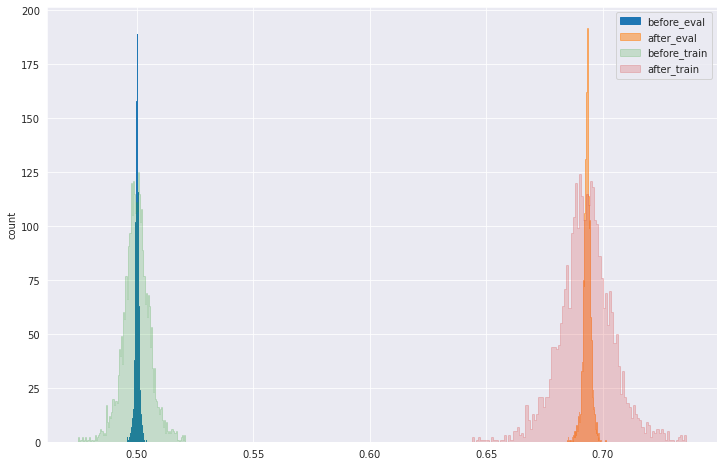

In [130]:
plt.figure(figsize=(12,8))
true = np.array(true_htm.detach().cpu())
#eval
dist_eval = np.array(pred_htm_eval.detach().cpu())
dist_after_eval = np.array(center_loss(true_htm,pred_htm_eval).detach().cpu())

plt.hist(dist_eval,bins=100,histtype='step',fill=True,label='before_eval')
plt.hist(dist_after_eval,bins=100,alpha=0.5,histtype='step',fill=True,label='after_eval')

#train
dist_train = np.array(pred_htm_train.detach().cpu())
dist_after_train = np.array(center_loss(true_htm,pred_htm_train).detach().cpu())

plt.hist(dist_train,bins=100,histtype='step',fill=True,label='before_train',alpha=0.2)
plt.hist(dist_after_train,bins=100,alpha=0.2,histtype='step',fill=True,label='after_train')

#plt.hist(dist,bins=100,histtype='step',fill=True,label='before_train')
#plt.hist(dist_after,color='purple',bins=100,alpha=0.5,histtype='step',fill=True,label='after_train')

#plt.hist(true,color='red',bins=100,alpha=0.5,histtype='step',fill=True,label='true')
plt.ylabel('count')
plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

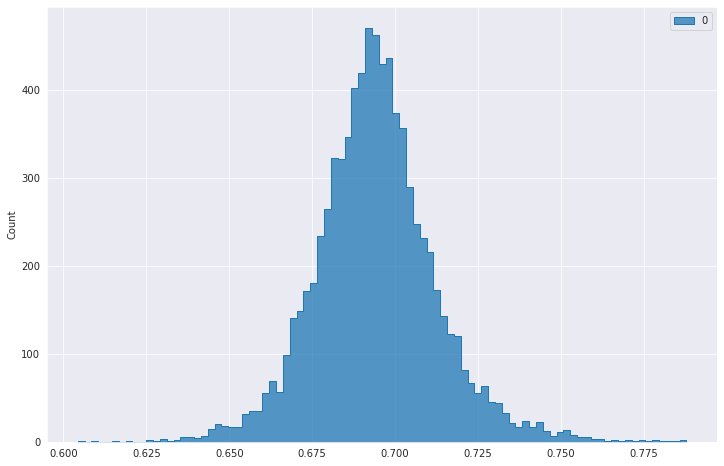

In [30]:
plt.figure(figsize=(12,8))
#dist = np.array(pred_htm.detach().cpu())
sns.set_style('darkgrid')
sns.histplot(dist,element='step')
sns.histplot(dist_after_train,element='step',color='purple')
sns.histplot(dist_after_train,element='step',color='orange')
sns.histplot(dist_after_train,element='step',color='')
sns.histplot(dist_after_train,element='step',color='purple')
#.set_title('x_entropy')